In [1]:
%load_ext autoreload
%autoreload 2

# Предисловие
## Тезисы
* хорошо, что данные более менее сбалансированы, не пришлось этим заниматься
* Старался где можно делать как можно менее 'инвазивно'
* Есть несколько путей построения графа
    * по хорошо описанному пути, и тем более показанному в репозитории (с графом напрямую из изображения и пуллингом) я решил не идти
        * Но, если бы я по нему прошел, надо было сначала превартить графики (60,5) в картину, где например 5 каналов, и матрица (k, 60), где k будет отрадать насколько подробно мы смотрим изменения ряда (условно если значения принимают только числа от 1 до 10, k будет равно 10) 
    * Я использовал связи в лаге (окне +-4) и при этом использовал не начальные числа (+нормализация) а лог разницы - 1 - отсюда можно очень много дальше придумать
        * логически это отображает насколько изменилось значение i+t относительно предыдщуего значения i - это часто используемая практика в работе с временными рядами
        * можно даже проредить связи поставив значения, если веса ниже них, связь удаляется
        * у нас по сути 5 типов данных, 4 из которых сильно связаны друг с другом - это я сейчас не использовал, но это точка роста
        * я использовал 5 типов связей между нодами - временем (60)
        * также чтобы нормально учитывать время - было два пути - направленный граф, или как-то время представитьв данных. Я использовал porsitional ecnoding для нод - это и есть изначальные вектора
        * сам алгоритмюазовой сети
            * основан на GCN
            * нода по-разному собирает информацию согласно разныим типам связи, можно настроить насколько далeко она видит (например соседей, соседей, соседей)
    * я использовал библиотеку torch geometric чтобы работать с графом
* я завершил на переписывании имплементации Tripplet network

## Пути улушчения
* огромные возможности в улучшении представления в виде графа
    * использовать статистику
    * есть идеи того, как можно удалять лишние связи (например сначала авторегрессией пройтись и найти лаги, которые плохо коррелируют) 
* улучшение архитектуры, разить на настощие плексы и сделать настоящую слоистую архитектуру
* тюнинг по гиперпараметрам - сейчас реультаты очень нестабильные, и сильно зависят от мелких изменений в параметрах

## Выводы
* Здесь не самые лучшие результаты, которые я видел, но я подобрал более менее
* Кластеры получается строить. Они различимы визуально. Ограничение размере выхода из сети. которая делает эмбеддинги в 2 элемента - жлемента не лучшим образом сказывается на качестве. Понятно зачем оно здесь, но можно использовать например TSNE и для визулизации а для рабоыт и предикшенов более высоки размерности
* Результаты классификации
    * любопытно что классифицировать сигналы buy у сети получается лучше (как 0 так и 1)
    * 

# Prepare dataset
We'll be working on MNIST dataset

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.nn import GCNConv
from trainer import fit
from metrics import AccumulatedAccuracyMetric
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cuda = torch.cuda.is_available()


import os
os.path.join("../")
from datasets import SiameseMNIST, TripletMNIST, BalancedBatchSampler, transform_data_to_graphs, GraphDataset
from torch_geometric.data import DataLoader

## Show and small demo of dataset

In [3]:
train_filenames = [['data/dataset/train_2022-06-01_2023-05-31_260d/buy_patterns.npy', 'data/dataset/train_2022-06-01_2023-05-31_260d/buy_patterns_clusters.npy'],
                   ['data/dataset/train_2022-06-01_2023-05-31_260d/sell_patterns.npy', 'data/dataset/train_2022-06-01_2023-05-31_260d/sell_patterns_clusters.npy']]

test_filenames = [['data/dataset/test_2023-06-01_2023-09-14_98d/buy_patterns.npy', 'data/dataset/test_2023-06-01_2023-09-14_98d/buy_patterns_clusters.npy'],
                   ['data/dataset/test_2023-06-01_2023-09-14_98d/sell_patterns.npy', 'data/dataset/test_2023-06-01_2023-09-14_98d/sell_patterns_clusters.npy']]

train_dataset = GraphDataset(transform_data_to_graphs(train_filenames))
test_dataset = GraphDataset(transform_data_to_graphs(test_filenames))

2it [00:21, 10.56s/it]
2it [00:02,  1.42s/it]


In [4]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

/Users/maratshikhragimov/common-env/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
for data, label in train_loader:
    break

In [6]:
data[1]

Data(x=[60, 10], edge_index_type_0=[2, 1090], edge_attr_type_0=[1090], edge_index_type_1=[2, 1090], edge_attr_type_1=[1090], edge_index_type_2=[2, 1090], edge_attr_type_2=[1090], edge_index_type_3=[2, 1090], edge_attr_type_3=[1090], edge_index_type_4=[2, 1090], edge_attr_type_4=[1090])

<Axes: >

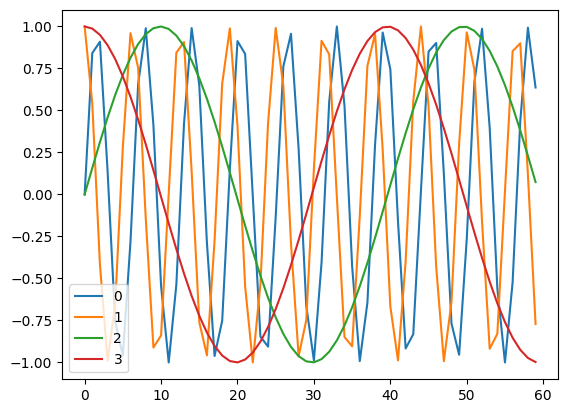

In [10]:
# postiional encoded embeddings
pd.DataFrame(data[1].x.numpy()[:, [0,1,2,3]]).plot()

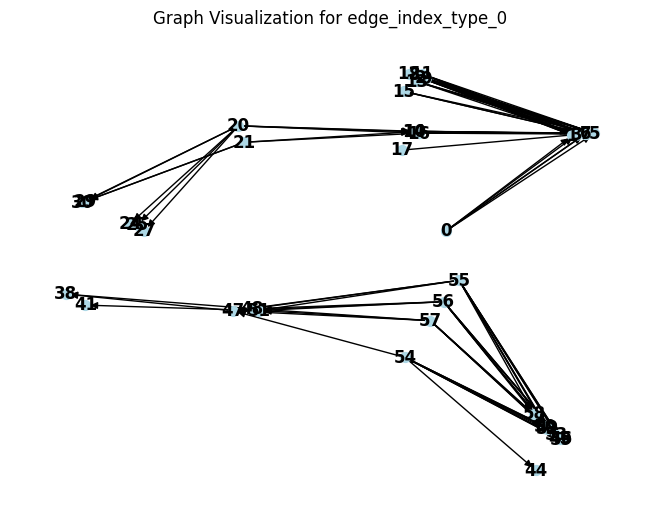

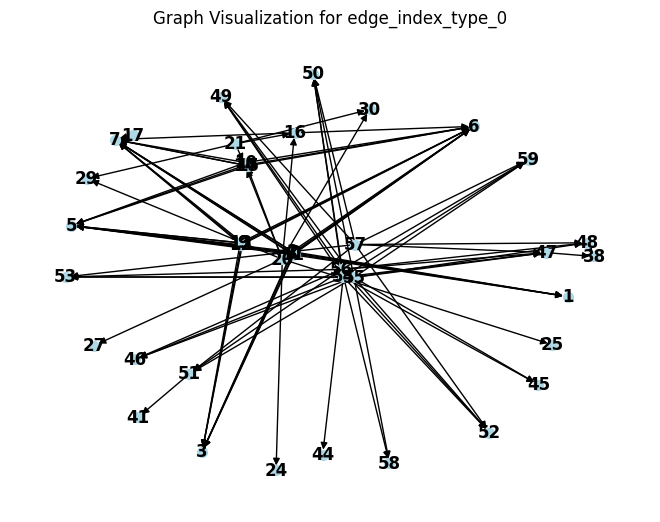

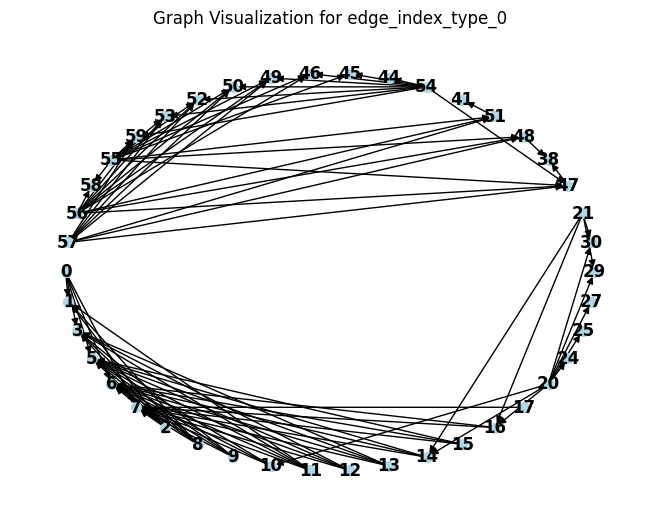

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, edge_index_name, edge_attr_name=None, threshold=0):
    G = nx.DiGraph()
    
    edge_indices = data[edge_index_name].numpy()
    if edge_attr_name:
        edge_attrs = data[edge_attr_name].numpy()
    else:
        edge_attrs = None
    
    for i, edge in enumerate(edge_indices.T): 
        src, dest = edge
        if edge_attrs is not None and edge_attrs[i]> threshold:
            G.add_edge(src, dest, weight=edge_attrs[i])


    pos = nx.spring_layout(G, seed=42) 
    pos = nx.kamada_kawai_layout(G)   # !!!
    # pos = nx.spectral_layout(G)   # NO
    pos = nx.shell_layout(G)  #
    # pos = nx.random_layout(G, seed=42)  
    
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, node_color='lightblue', node_size=50, with_labels=True, font_weight='bold')
    plt.title('Graph Visualization for ' + edge_index_name)
    plt.show()

    pos = nx.spring_layout(G, seed=42) 
    nx.draw(G, pos, node_color='lightblue', node_size=50, with_labels=True, font_weight='bold')
    plt.title('Graph Visualization for ' + edge_index_name)
    plt.show()

    pos = nx.shell_layout(G)
    nx.draw(G, pos, node_color='lightblue', node_size=50, with_labels=True, font_weight='bold')
    plt.title('Graph Visualization for ' + edge_index_name)
    plt.show()

visualize_graph(data[1], 'edge_index_type_0', 'edge_attr_type_0', threshold=0.7)

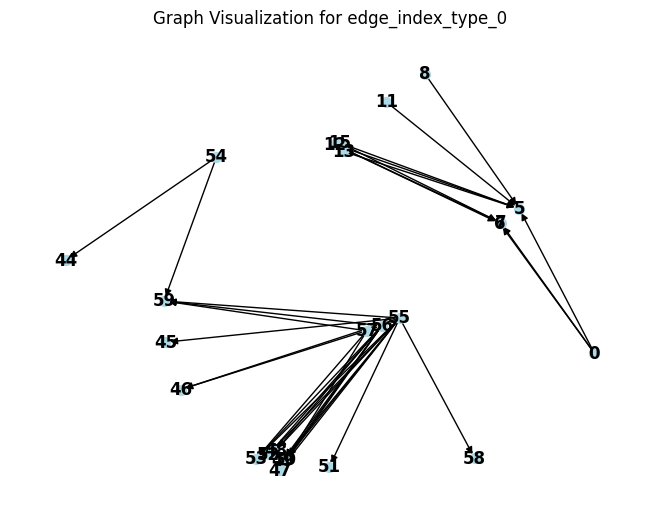

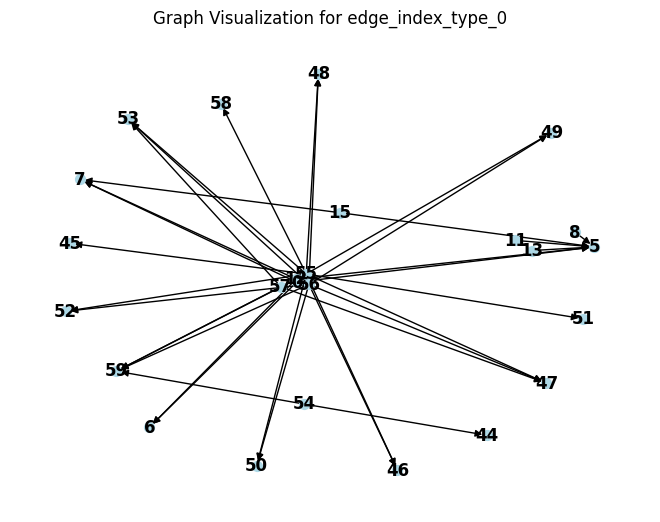

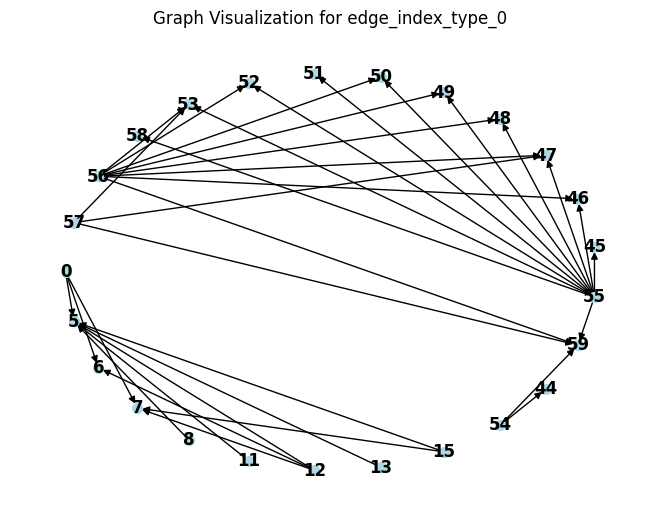

In [20]:
visualize_graph(data[1], 'edge_index_type_0', 'edge_attr_type_0', threshold=0.8)

## Common setup

In [21]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

classes = ['0', '1', '2', '3']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [22]:
# Set up data loaders
batch_size = 64
embedding_dim = 28
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# Set up the network and training parameters
from networks import GCNBaseNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = GCNBaseNet(num_features=10, num_relations=5, embedding_dim=embedding_dim, num_layers=1)
model = ClassificationNet(embedding_net, n_classes=4)

loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 50

In [23]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

/Users/maratshikhragimov/common-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/735 (0%)]	Loss: 1.526642	Accuracy: 12.5

Epoch: 1/50. Train set: Average loss: 1.4460	Accuracy: 23.94557823129252
Epoch: 1/50. Validation set: Average loss: 1.3847	Accuracy: 31.632653061224488
Train: [0/735 (0%)]	Loss: 1.412308	Accuracy: 20.3125

Epoch: 2/50. Train set: Average loss: 1.3868	Accuracy: 29.1156462585034
Epoch: 2/50. Validation set: Average loss: 1.3868	Accuracy: 20.408163265306122
Train: [0/735 (0%)]	Loss: 1.366486	Accuracy: 15.625

Epoch: 3/50. Train set: Average loss: 1.3464	Accuracy: 33.06122448979592
Epoch: 3/50. Validation set: Average loss: 1.3233	Accuracy: 44.89795918367347
Train: [0/735 (0%)]	Loss: 1.290398	Accuracy: 50.0

Epoch: 4/50. Train set: Average loss: 1.2105	Accuracy: 42.44897959183673
Epoch: 4/50. Validation set: Average loss: 1.2213	Accuracy: 38.775510204081634
Train: [0/735 (0%)]	Loss: 1.224814	Accuracy: 29.6875

Epoch: 5/50. Train set: Average loss: 0.9694	Accuracy: 50.61224489795919
Epoch: 5/50. Validation set: Average loss: 1.2693	Accuracy

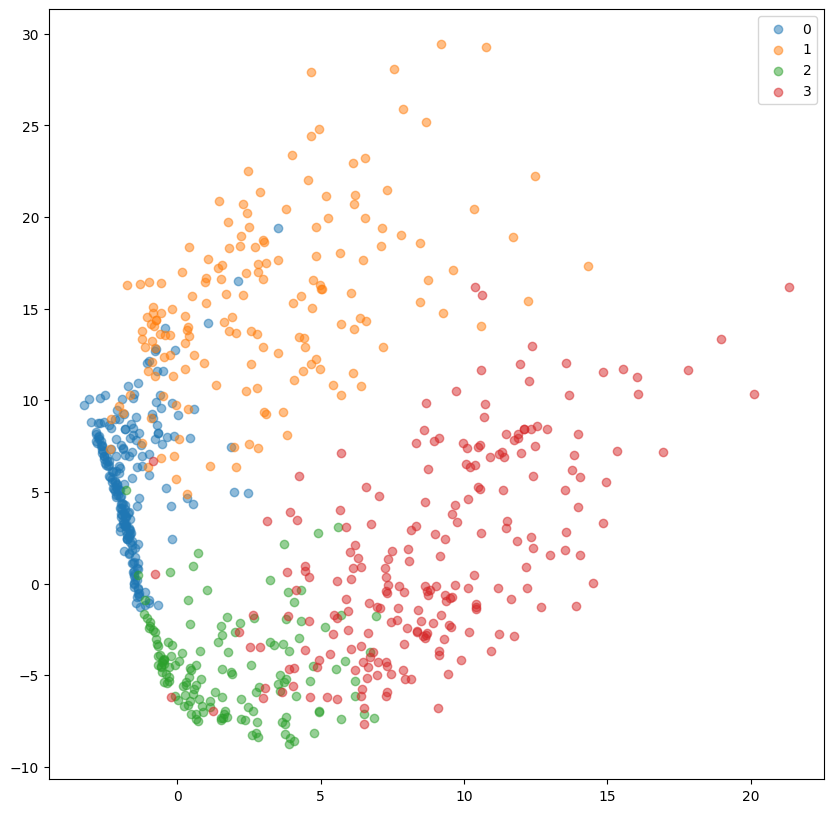

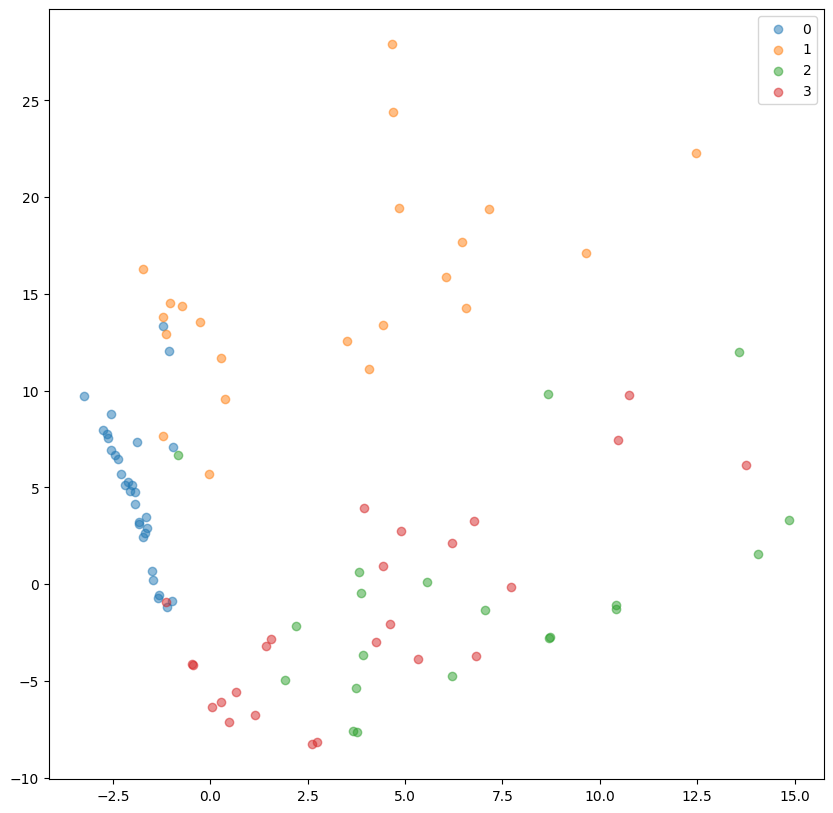

In [24]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

In [25]:
targets = []
outputs = []
for batch_idx, (data, target) in enumerate(test_loader):
    model.eval()
    target = target if len(target) > 0 else None
    if not type(data) in (tuple, list):
        data = (data,)

    outputs_ = model(*data)
    outputs.extend(outputs_)
    targets.extend(target)
    
outputs = torch.stack(outputs)
targets = torch.stack(targets)
probabilities = F.softmax(outputs, dim=1)
rounded_probabilities = torch.round(probabilities * 100) / 100

y_pred = np.argmax(rounded_probabilities.detach().numpy(), axis=1)
y_true = targets.numpy()

In [26]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89        31
           1       0.91      0.91      0.91        22
           2       0.30      0.30      0.30        20
           3       0.50      0.52      0.51        25

    accuracy                           0.67        98
   macro avg       0.65      0.65      0.65        98
weighted avg       0.68      0.67      0.68        98



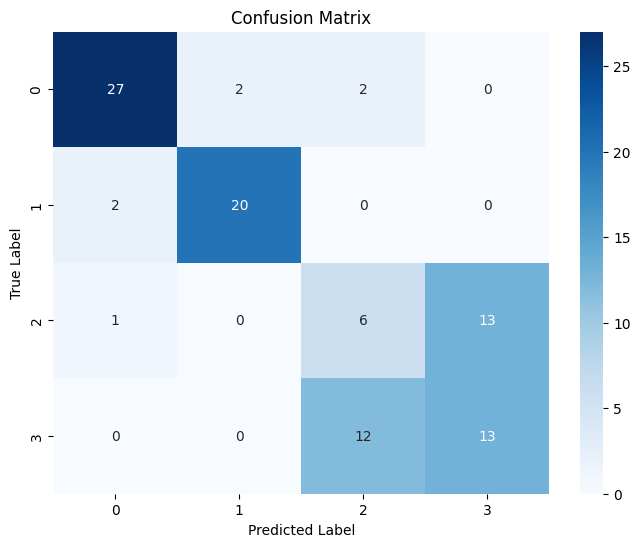

In [27]:
cm = confusion_matrix(y_true, y_pred)
labels = np.unique(y_true) 

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [28]:
# Set up data loaders
from torch_geometric.data import DataLoader

from datasets import SiameseGCN
import datasets as datas
import importlib
importlib.reload(datas)
siamese_train_dataset = datas.SiameseGCN(train_dataset, train=True)
siamese_test_dataset = datas.SiameseGCN(test_dataset)
batch_size = 64
embedding_dim=64
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import GCNBaseNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = GCNBaseNet(num_features=10, num_relations=5, embedding_dim=embedding_dim, num_layers=3)
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

/Users/maratshikhragimov/common-env/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [29]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/Users/maratshikhragimov/common-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/735 (0%)]	Loss: 0.234269

Epoch: 1/20. Train set: Average loss: 0.2189
Epoch: 1/20. Validation set: Average loss: 0.1163
Train: [0/735 (0%)]	Loss: 0.149069

Epoch: 2/20. Train set: Average loss: 0.1294
Epoch: 2/20. Validation set: Average loss: 0.0977
Train: [0/735 (0%)]	Loss: 0.126303

Epoch: 3/20. Train set: Average loss: 0.1114
Epoch: 3/20. Validation set: Average loss: 0.0832
Train: [0/735 (0%)]	Loss: 0.118131

Epoch: 4/20. Train set: Average loss: 0.0986
Epoch: 4/20. Validation set: Average loss: 0.0982
Train: [0/735 (0%)]	Loss: 0.119166

Epoch: 5/20. Train set: Average loss: 0.0860
Epoch: 5/20. Validation set: Average loss: 0.0785
Train: [0/735 (0%)]	Loss: 0.077939

Epoch: 6/20. Train set: Average loss: 0.0812
Epoch: 6/20. Validation set: Average loss: 0.0958
Train: [0/735 (0%)]	Loss: 0.080900

Epoch: 7/20. Train set: Average loss: 0.0814
Epoch: 7/20. Validation set: Average loss: 0.1168
Train: [0/735 (0%)]	Loss: 0.066792

Epoch: 8/20. Train set: Average loss: 0.0739
Ep

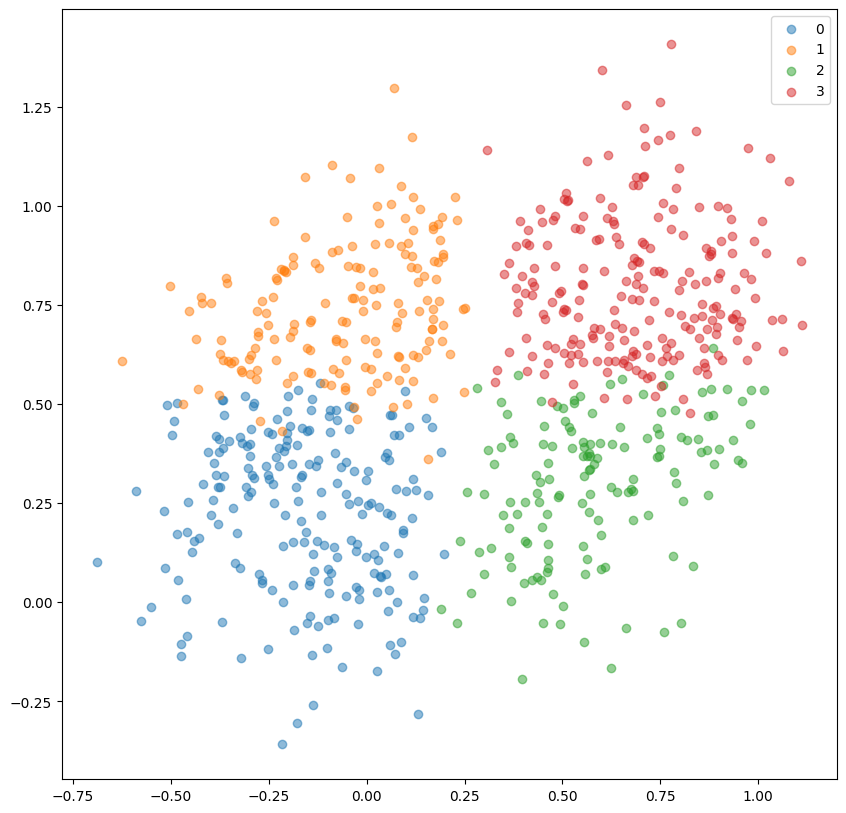

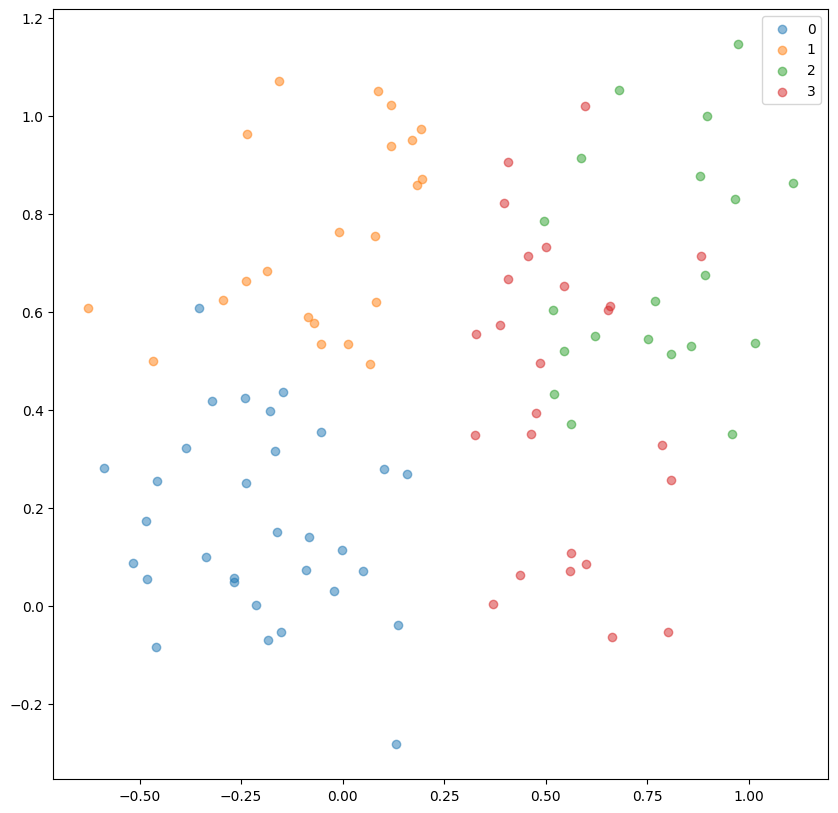

In [30]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [31]:
# Set up data loaders
# from datasets import TripletGCN
from torch_geometric.data import DataLoader
import datasets as datas
import importlib
importlib.reload(datas)

triplet_train_dataset = datas.TripletGCN(train_dataset, train=True) # Returns triplets of images
triplet_test_dataset = datas.TripletGCN(test_dataset)

batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


# siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
# siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import GCNBaseNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = GCNBaseNet(num_features=10, num_relations=5, embedding_dim=embedding_dim, num_layers=3)
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
log_interval = 100

In [32]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/735 (0%)]	Loss: 1.000000

Epoch: 1/10. Train set: Average loss: 0.9999
Epoch: 1/10. Validation set: Average loss: 0.9984
Train: [0/735 (0%)]	Loss: 0.999084

Epoch: 2/10. Train set: Average loss: 0.8263
Epoch: 2/10. Validation set: Average loss: 0.6902
Train: [0/735 (0%)]	Loss: 0.505489

Epoch: 3/10. Train set: Average loss: 0.5722
Epoch: 3/10. Validation set: Average loss: 0.4593
Train: [0/735 (0%)]	Loss: 0.496931

Epoch: 4/10. Train set: Average loss: 0.4942
Epoch: 4/10. Validation set: Average loss: 0.5582
Train: [0/735 (0%)]	Loss: 0.540721

Epoch: 5/10. Train set: Average loss: 0.4774
Epoch: 5/10. Validation set: Average loss: 0.4136
Train: [0/735 (0%)]	Loss: 0.414498

Epoch: 6/10. Train set: Average loss: 0.3979
Epoch: 6/10. Validation set: Average loss: 0.2647
Train: [0/735 (0%)]	Loss: 0.469812

Epoch: 7/10. Train set: Average loss: 0.3542
Epoch: 7/10. Validation set: Average loss: 0.2794
Train: [0/735 (0%)]	Loss: 0.396326

Epoch: 8/10. Train set: Average loss: 0.3309
Ep

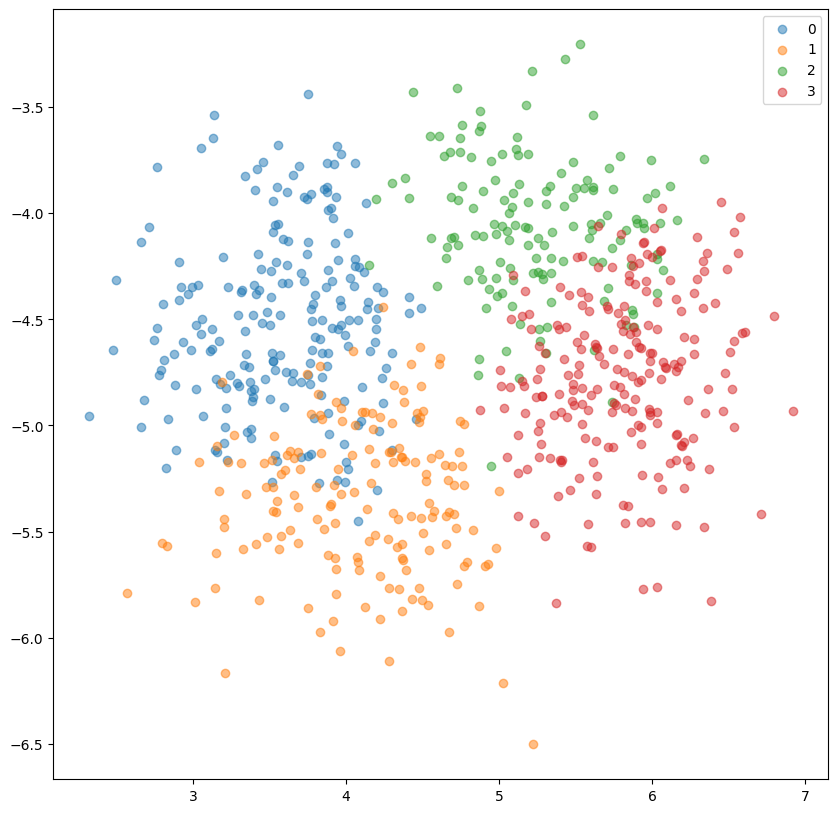

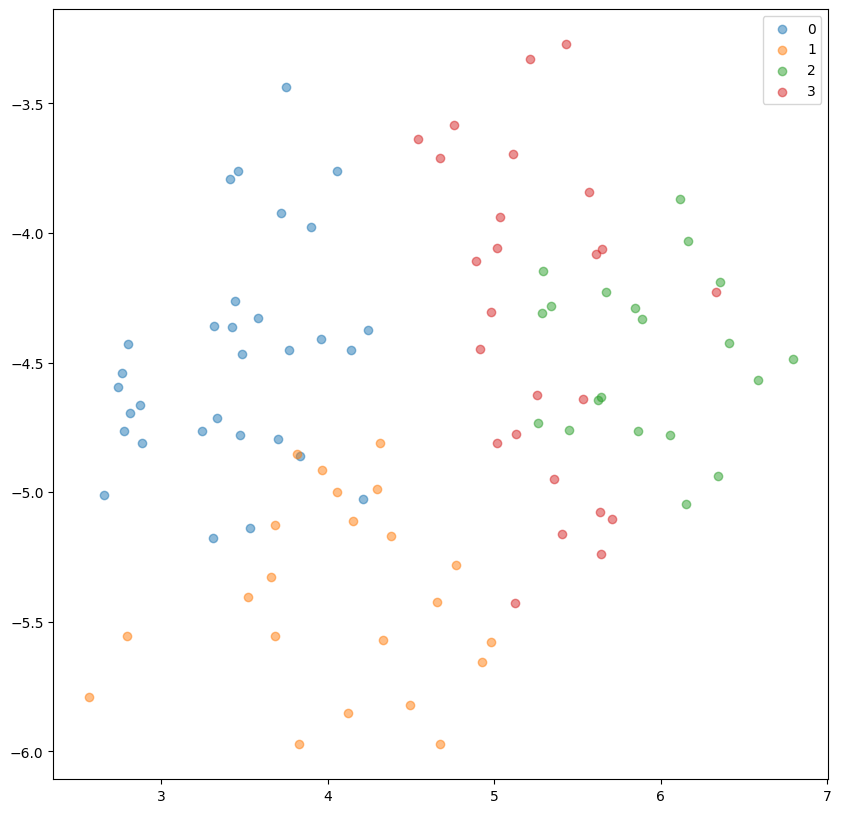

In [33]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Дальше не сделал

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [13]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [14]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.491550
Train: [12500/60000 (21%)]	Loss: 0.270060
Train: [25000/60000 (42%)]	Loss: 0.139297
Train: [37500/60000 (62%)]	Loss: 0.096533
Train: [50000/60000 (83%)]	Loss: 0.076680
Epoch: 1/20. Train set: Average loss: 0.1338
Epoch: 1/20. Validation set: Average loss: 0.0537
Train: [0/60000 (0%)]	Loss: 0.052101
Train: [12500/60000 (21%)]	Loss: 0.052579
Train: [25000/60000 (42%)]	Loss: 0.047850
Train: [37500/60000 (62%)]	Loss: 0.037767
Train: [50000/60000 (83%)]	Loss: 0.037061
Epoch: 2/20. Train set: Average loss: 0.0418
Epoch: 2/20. Validation set: Average loss: 0.0325
Train: [0/60000 (0%)]	Loss: 0.015191
Train: [12500/60000 (21%)]	Loss: 0.027951
Train: [25000/60000 (42%)]	Loss: 0.025129
Train: [37500/60000 (62%)]	Loss: 0.026858
Train: [50000/60000 (83%)]	Loss: 0.024246
Epoch: 3/20. Train set: Average loss: 0.0254
Epoch: 3/20. Validation set: Average loss: 0.0274
Train: [0/60000 (0%)]	Loss: 0.010963
Train: [12500/60000 (21%)]	Loss: 0.019170
Train: [25000/60000 (

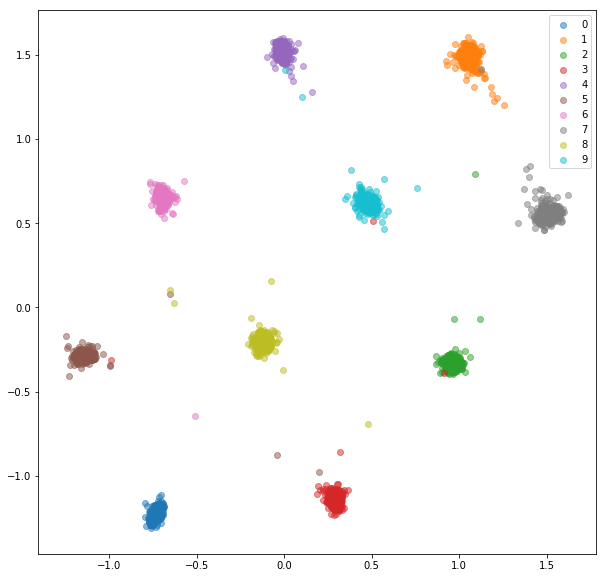

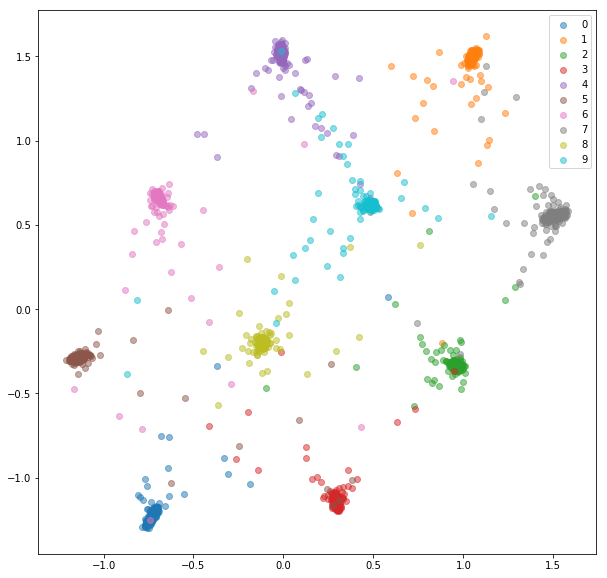

In [15]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [16]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [17]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999806	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.989613	Average nonzero triplets: 2648.725490196078
Train: [25000/60000 (42%)]	Loss: 0.994085	Average nonzero triplets: 2328.5346534653463
Train: [37500/60000 (62%)]	Loss: 0.958655	Average nonzero triplets: 2115.5165562913908
Train: [50000/60000 (83%)]	Loss: 0.976330	Average nonzero triplets: 1921.4925373134329
Epoch: 1/20. Train set: Average loss: 0.9805	Average nonzero triplets: 1801.7071129707113
Epoch: 1/20. Validation set: Average loss: 0.8326	Average nonzero triplets: 1218.6410256410256
Train: [0/60000 (0%)]	Loss: 0.876484	Average nonzero triplets: 1217.0
Train: [12500/60000 (21%)]	Loss: 0.991039	Average nonzero triplets: 975.3529411764706
Train: [25000/60000 (42%)]	Loss: 0.992353	Average nonzero triplets: 934.009900990099
Train: [37500/60000 (62%)]	Loss: 1.075175	Average nonzero triplets: 917.0596026490066
Train: [50000/60000 (83%)]	Loss: 1.023091	Average nonzero triplets: 889

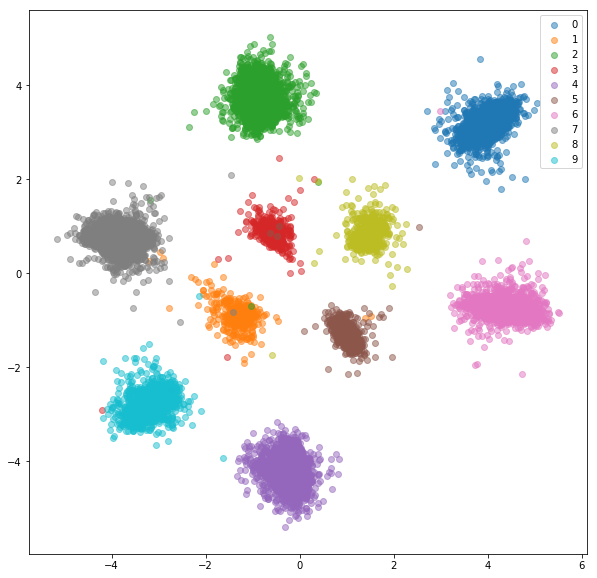

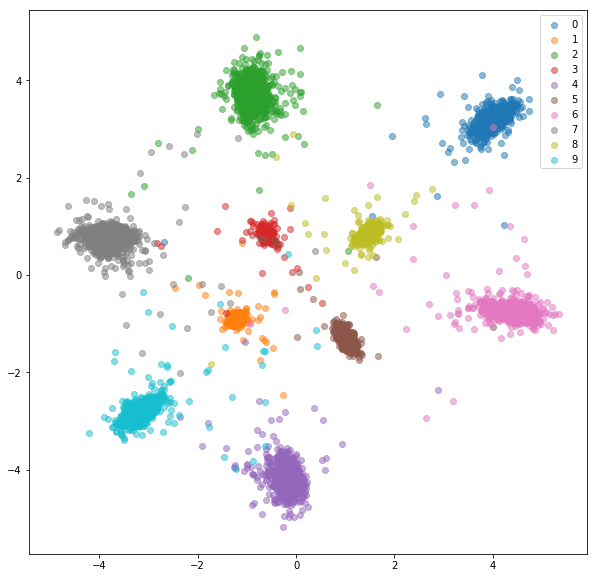

In [18]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

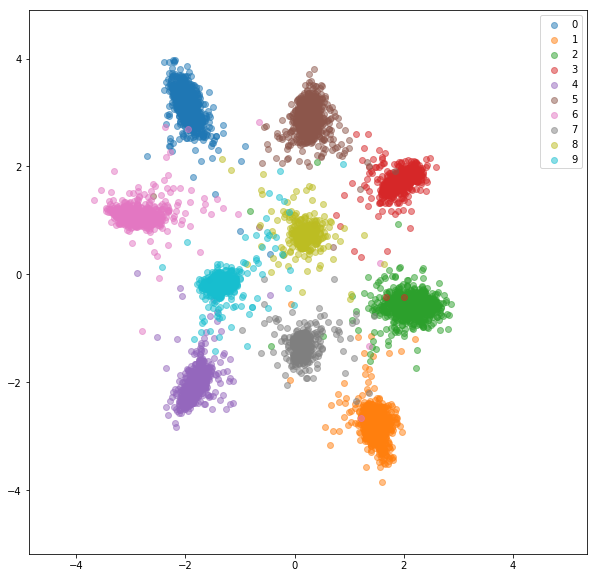

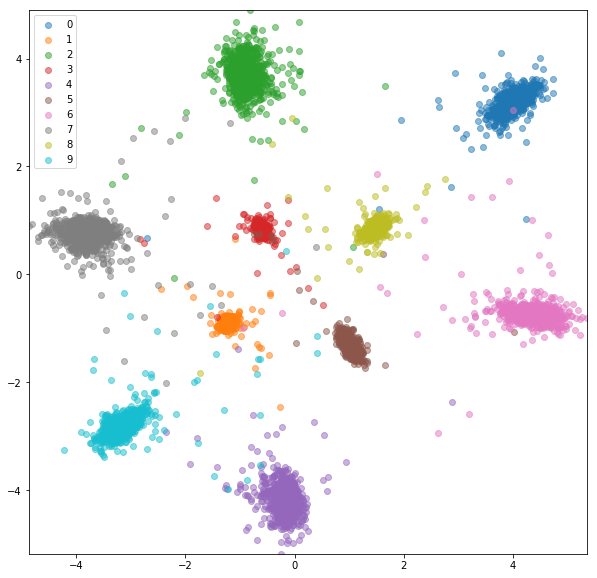

In [19]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

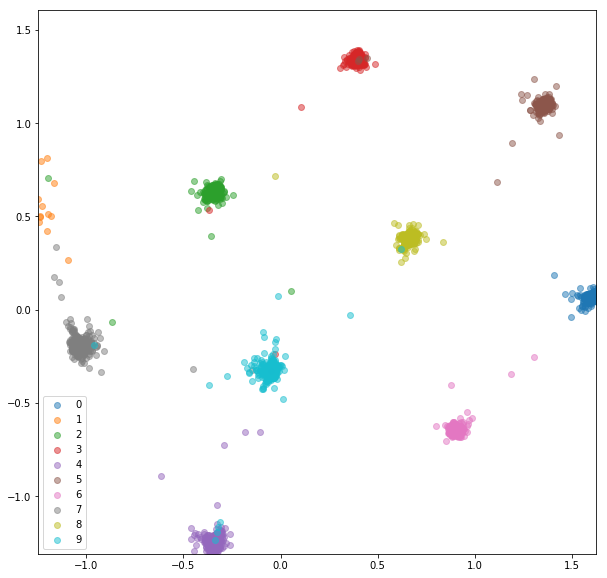

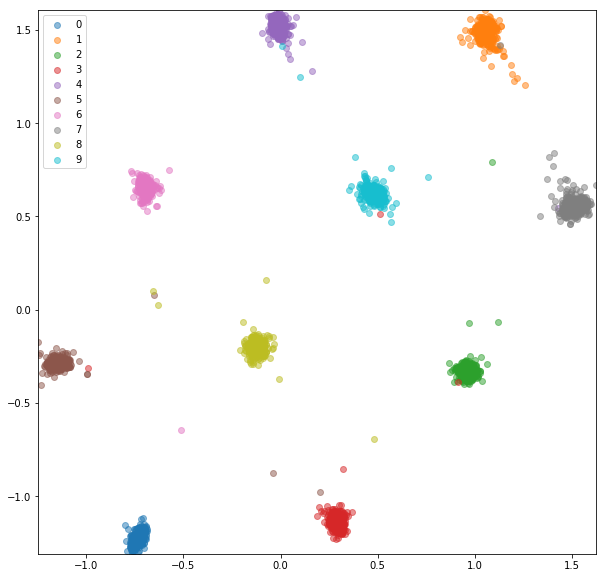

In [20]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)